# Reinvent 2018 - ARC329 - Massively Parallel Data Processing at Scale
This notebook will walk you through the session Massively Parallel Data Processing at Scale.  We will use Landsat-8 satellite imagery to calculate a Normalized Differnece Vegetation Index (NDVI) for a few interesting locations around the world evaluating the GeoTIFF data across multiple spectrum bands. [Landsat 8 scenes held on AWS](https://landsatonaws.com/)

### What is NDVI (Normalized Difference Vegetation Index)?

Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). NDVI always has a range from -1 to +1 with no distinct boundary for types of land cover. For example, when you have negative values, it is likely that the majority of the scene is water. In contrast, if the NVDI for a given scene calculates to a value close to +1, there is a higher possibility that the scens contains dense green vegetation. When NDVI is close to zero, there are no green leaves and it could even be an urbanized area.

The formula to calculate NDVI is as follows.  For more details pertaining to how we are calculating NDVI in our examples, refer to file **l8_nvdi.py** in the source provided.  This file contains the functions we will be using in this session to calulate NDVI.


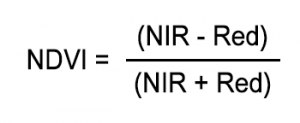

### Credits
- Pywren-WorkShops - This Session builds upon work done in Lab-4 of the Pywren workshop
- NDVI PyWren - [Peter Scarth](mailto:p.scarth@uq.edu.au?subject=AWS%20Lambda%20and%20PyWren) (Joint Remote Sensing Research Program)
- [RemotePixel](https://github.com/RemotePixel/remotepixel-api) - Landsat 8 NDVI GeoTIFF parsing function
- [PyWren](https://github.com/pywren/pywren) - Project by BCCI and Riselab. This project makes it easy to execute massive parallel map queries across [AWS Lambda](https://aws.amazon.com/lambda/)

#### Additional notes
The functions we use in this session will deliver results normally in under a minute for the full timeseries of more than 100 images, and we can simply plot the resulting timeseries or do further analysis. BUT, the points may well be cloud or cloud shadow contaminated. We have not done any cloud masking to the imagery, but we do have the scene metadata that indicates the probable amount of clouds across the entire scene. We use this to weight a [smoothing spline](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html), such that an observation with no clouds over the scene has full weight, and an observation with 100% of the scene covered with clouds has zero weight.  

# Step by Step Instructions

### Prepare the Environment
This section will setup all the necessary libraries we will be using to properly display our results, and also defines some variables and functions used throughout the session. We will import a library that allows us to query Landsat 8 data from the [AWS Public Dataset](https://aws.amazon.com/public-datasets/landsat/):

Let's take a couple of minutes to walk through this initial code.

In [ ]:
import requests, json, numpy, random, time, datetime, os, boto3, folium
from IPython.display import HTML, display, Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import l8_ndvi
from scipy.interpolate import UnivariateSpline
import pywren

#AWS Region and Pywren Lambda Function Name - Update wth your values from the PyWren Setup
AWSRegion = 'PyWren Setup AWS Region'
LambdaName = 'PyWren Setup Function Name'
LambdaS3Bucket='PyWren Setup S3 Bucket Name'



LambdaS3Key='lambda_function.zip'


#The following define the locations we will be pulling Landsat-8 data for and processing
ColumbiaCoffeeLabel = 'Columbia Coffee Triangle'
ColumbiaCoffee = '-75.6816,5.4716'
ColumbiaCoffeeEstimatedNonMPP = 0

CaNapaValleyLabel = 'California Napa Valley'
CaNapaValley = '-122.2868,38.2975'
CaNapaValleyEstimatedNonMPP = 0

DeathValleyLabel = 'Death Valley USA'
DeathValley = '-116.9325,36.5322'
DeathValleyEstimatedNonMPP = 0

SulaVineyardLabel = 'Sula Vineyard, Maharashtra India'
SulaVineyard = '73.6885,20.0068'
SulaVineyardEstimatedNonMPP = 0

lonLat = ''




# Function to return a Landsat 8 scene list given a Longitude, Latitude string
# This uses the amazing developmentseed Satellite API
# https://github.com/sat-utils/sat-api
def getSceneList(locallonLat):
    lonLat = locallonLat
    scenes=[]
    url = "https://api.developmentseed.org/satellites/landsat"
    params = dict(
        contains=lonLat,
        satellite_name="landsat-8",
        limit="1000") 
    # Call the API to grab the scene metadata
    sceneMetaData = json.loads(requests.get(url=url, params=params).content)
    # Parse the metadata
    #print(sceneMetaData)
    for record in sceneMetaData["results"]:
        scene = str(record['aws_index'].split('/')[-2]) 
        # This is a bit of a hack to get around some versioning problem on the API :(
        # Related to this issue https://github.com/sat-utils/sat-api/issues/18 
        if scene[-2:] == '01':
            scene = scene[:-2] + '00'
        if scene[-2:] == '02':
            scene = scene[:-2] + '00'
        if scene[-2:] == '03':
            scene = scene[:-2] + '02'
        scenes.append(scene)   
    return scenes


# Function to call a AWS Lambda function to drill a single pixel and compute the NDVI
def getNDVI(scene):
    return l8_ndvi.point(scene, eval(lonLat))

# Function to Display Single Scene Data and plot location on map using folium
def displaySingleScene(scene,locallonLat,locationName,locationTotalSceneCount):
    lonLat = locallonLat
    localTotalTimeEstimate = 0
    thumbnail = l8_ndvi.thumb(scene, eval(lonLat))
    display(Image(url=thumbnail, format='jpg'))
    SceneMap = None
    SceneMap = folium.Map(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])],zoom_start=4,width=400,height=300)
    folium.Marker(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])]).add_to(SceneMap)
    starttime=time.time()
    result = getNDVI(scene)
    endtime = time.time()
    localTotalEstimate = (endtime-starttime)*locationTotalSceneCount
    display(HTML('<b>Date:</b> '+result['date']))
    display(HTML('<b>SceneID:</b> '+ scene))
    display(HTML('<b>Location:</b> '+ locationName))
    display(HTML('<b>Amount of clouds:</b> '+str(result['cloud'])+'%'))
    display(HTML('<b>NDVI:</b> '+str(result['ndvi'])))
    display(HTML('<b>Process Time in Sec:</b> '+str(endtime-starttime)))
    display(HTML('<b>Estimated Time in Sec to process all images in for this location </b> ' +str(localTotalEstimate) ))
    display(SceneMap)
    return localTotalEstimate

#Function to process All Landsat-8 images in a given Scene using PyWren in a MPP manner. 
def processScenesMPP(scenes,locallonLat,locationName,localTotalEstimate):
    lonLat = locallonLat
    index = len(scenes)
    pwex = pywren.default_executor()
    starttime=time.time()
    results = pywren.get_all_results(pwex.map(getNDVI, scenes[:index]))
    endtime = time.time()
    EstMPPTimeSaving = localTotalEstimate - (endtime-starttime)
    results = filter(None, results)
    display(HTML('<b>Location Name: </b>'+locationName))
    display(HTML('<b>Scenes Processed:</b> '+str(len(scenes))))
    display(HTML('<b>Scenes With Data:</b> '+str(len(results))))
    display(HTML('<b>Process Time in Sec:</b> '+str(endtime-starttime)))
    display(HTML('<b>Estimated Time Saved using MPP:</b> '+str(EstMPPTimeSaving)))
    display(HTML('<b>---------------------------------</b> '))
    return results

#Function to Display results returned from our MPP process of a given location.  This uses Pandas Dataframes to display
#Data in a table and folium to map the location
def displayMPPResults(results,locallonLat,locationName):
    lonLat = locallonLat
    series = pd.DataFrame(results)
    series = series[::-1]
    series = series[['date','cloud','ndvi']]
    redColors = sb.light_palette("blue",as_cmap=True)
    greenColors = sb.light_palette("green",as_cmap=True)
    display(HTML('<b>Location:</b> '+locationName))
    display(HTML('<b>Average NDVI:</b> '+str(series['ndvi'].mean())))
    display(HTML('<b>Average Cloud %:</b> '+str(series['cloud'].mean())))
    with pd.option_context('display.max_rows',None,'display.max_columns',None):
        display(series.style.background_gradient(cmap=redColors,subset=['cloud']).highlight_max(subset=['cloud']).set_caption(locationName).hide_index().background_gradient(cmap=greenColors,subset=['ndvi']).highlight_max(subset=['ndvi']))
    SceneMap = None
    SceneMap = folium.Map(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])],zoom_start=4,width=400,height=300)
    folium.Marker(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])]).add_to(SceneMap)
    display(SceneMap)


def plotMPPResults(results,locallonLat,locationName):
    timeSeries = filter(None,results)
    #Use DataFrame to remove duplicate dates.  Two datapoints with same date will cause fitTime to contain invalid datapoints for plotting
    dfTS = pd.DataFrame.from_dict(timeSeries)
    dfTSU = dfTS.drop_duplicates(subset='date',keep='last',inplace=False)
    timeSeries = dfTSU.to_dict('records')
    # Extract the data trom the list of results
    timeStamps = [datetime.datetime.strptime(obs['date'],'%Y-%m-%d') for obs in timeSeries if 'date' in obs]
    ndviSeries = [obs['ndvi'] for obs in timeSeries if 'ndvi' in obs]
    cloudSeries = [obs['cloud']/100 for obs in timeSeries if 'cloud' in obs]

    # Create a time variable as the x axis to fit the observations
    # First we convert to seconds
    timeSecs = numpy.array([(obsTime-datetime.datetime(1970,1,1)).total_seconds() for obsTime in timeStamps])
    # And then normalize from 0 to 1 to avoid any numerical issues in the fitting
    fitTime = ((timeSecs-numpy.min(timeSecs))/(numpy.max(timeSecs)-numpy.min(timeSecs)))
    # Smooth the data by fitting a spline weighted by cloud amount
    smoothedNDVI=UnivariateSpline(
        fitTime[numpy.argsort(fitTime)],
        numpy.array(ndviSeries)[numpy.argsort(fitTime)],
        w=(1.0-numpy.array(cloudSeries)[numpy.argsort(fitTime)])**2.0,
        k=2,
        s=0.1)(fitTime)

    fig = plt.figure(figsize=(16,10))
    plt.plot(timeStamps,ndviSeries, 'gx',label='Raw NDVI Data')
    plt.plot(timeStamps,ndviSeries, 'y:', linewidth=1)
    plt.plot(timeStamps,cloudSeries, 'b.', linewidth=1,label='Scene Cloud Percent')
    plt.plot(timeStamps,cloudSeries, 'b:', linewidth=1)
    plt.plot(timeStamps,smoothedNDVI, 'r--', linewidth=3,label='Cloudfree Weighted Spline')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('NDVI', fontsize=16)
    plt.title(locationName, fontsize=20)
    plt.grid(True)
    plt.ylim([-.1,1.0])
    plt.legend(fontsize=14)
    plt.show()
    lonLat = locallonLat
    SceneMap = None
    SceneMap = folium.Map(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])],zoom_start=4,width=400,height=300)
    folium.Marker(location=[float(lonLat.split(',')[1]),float(lonLat.split(',')[0])]).add_to(SceneMap)
    display(SceneMap)
    display(HTML('<b>---------------------------------------------------------</b> '))
    

# Get Scene Lists
The First thing we are going to do is call **getSceneList** for each of our locations of interest.  We will use the data in the returned lists to get specific images for processing.


In [ ]:
scenesColumbiaCoffee = getSceneList(ColumbiaCoffee)
scenesCaNapaValley = getSceneList(CaNapaValley)
scenesDeathValley = getSceneList(DeathValley)
scenesSulaVineyard = getSceneList(SulaVineyard)

display(HTML('Total Columbia Coffee Scenes: <b>' + str(len(scenesColumbiaCoffee)) + '</b>'))
display(HTML('Total Napa Valley Scenes: <b>' + str(len(scenesCaNapaValley)) + '</b>'))
display(HTML('Total Death Valley Scenes: <b>' + str(len(scenesDeathValley)) + '</b>'))
display(HTML('Total Sula Vineyard Scenes: <b>' + str(len(scenesSulaVineyard)) + '</b>'))


You may have noticed by the scene counts, not all locations have the same ammount of data. This is related to satellite orbits and how may passes a given location is seen by the satellite in a given year.

## Get familiar with the data

Now that we have our scene lists, let's take a look at a single date in the first location. We will be calling **diaplaySingleScene** with a random index on our first location's scene list. Running this cell a few times will give you an idea of the differences in the image clarity and level of cloud cover over time for the same location and also a feel for how long it takes to process a single image. Later in this session we will be using PyWren and Lambda to process ALL images in a given scene at once.

## Let's have a look at a Columbian Coffee Field

In [ ]:
lonLat=ColumbiaCoffee
ColumbiaCoffeeEstimatedNonMPP = displaySingleScene(random.choice(scenesColumbiaCoffee),ColumbiaCoffee,ColumbiaCoffeeLabel,len(scenesColumbiaCoffee))


## Review Results
Have a look at the output above and get a feel for the type of data we will be working with.  Take note of the time it took to process a single image, we have also used this time to calculate an estimate of how long it may take to process the entire image set for this scene one at a time.  Notice as the cloud percentage increases, the NDVI decreases.  This is because we have less light and less reflectivity/absorption from possible vegetation in the scene.  As we stated above, we are not masking for clouds in our calculations so in theory there may be a scene with a very good NDVI score being skewed slightly by cloud cover.

## Let's take a look at Napa Valley

In [ ]:
lonLat=CaNapaValley
CaNapaValleyEstimatedNonMPP = displaySingleScene(random.choice(scenesCaNapaValley),CaNapaValley, CaNapaValleyLabel,len(scenesCaNapaValley))

## Now Death Valley

In [ ]:
lonLat=DeathValley
DeathValleyEstimatedNonMPP = displaySingleScene(random.choice(scenesDeathValley),DeathValley, DeathValleyLabel,len(scenesDeathValley))

Notice in Death Valley, we get low NDVI even when the cloud cover percentage is low.  This is because there isn't much if any vegetation to report back to the LandSat Sensor Array either reflected or absorbed light levels.

## And Finally Sula Vineyard, India

In [ ]:
lonLat=SulaVineyard
SulaVineyardEstimatedNonMPP = displaySingleScene(random.choice(scenesSulaVineyard),SulaVineyard, SulaVineyardLabel,len(scenesSulaVineyard))

## Review the results from all above single images runs
As you can see each of these single processes took on average 2 seconds to complete.  If we had 1000 images, this would take over 30 min to process.  Now that we have a good baseline for timing, let's move on to the MPP part of this session.

### Massively Parallel Processing with PyWren

Now let's try this with multiple scenes and send it to PyWren, however to accomplish this we need to change our PyWren AWS Lambda function to include the necessary libraries such as rasterio and GDAL. Since those libraries are compiled C code, PyWren will not be able to pickle it up and send it to the Lambda function. Hence we will update the entire PyWren function to include the necessary binaries that have been compiled on an Amazon EC2 instance with Amazon Linux. We pre-packaged this and made it available via **NeedLocation**

Running the cell below will update the Lambda Function that the PyWren installer created.  Before running this, make sure the **LambdaName** and **AWSRegion** variables are defined in the initialization cell at the top of this notebook and match those used when configuring PyWren-Setup.

In [ ]:
lambdaclient = boto3.client('lambda', AWSRegion)

response = lambdaclient.update_function_code(
    FunctionName=LambdaName,
    Publish=True,
    S3Bucket=LambdaS3Bucket,
    S3Key=LambdaS3Key
)

response = lambdaclient.update_function_configuration(
    FunctionName=LambdaName,
    Environment={
        'Variables': {
            'GDAL_DATA': '/var/task/lib/gdal'
        }
    }
)

## Ok Now that we have updated our AWS Lambda Function
As you may have noticed, each of our locations has over 100 scenes with two locations having more than 300 scenes. This is a good use-case for PyWren as it will allow us to have AWS Lambda perform the calculation of NDVI and clouds for us in parallel. Running the calculation in AWS will also be more efficiant when pulling images from the LandSat-8 data set stored in S3. 

Ok let's run the full scene list for the Columbian Coffee Triangle to generate our dataset for future processing.

In [ ]:
lonLat = ColumbiaCoffee
resultsColumbiaCoffee = processScenesMPP(scenesColumbiaCoffee,ColumbiaCoffee,ColumbiaCoffeeLabel,ColumbiaCoffeeEstimatedNonMPP)


### Now let's get our dataset for Napa Valley

In [ ]:
lonLat = CaNapaValley
resultsCaNapaValley = processScenesMPP(scenesCaNapaValley,CaNapaValley,CaNapaValleyLabel,CaNapaValleyEstimatedNonMPP)

### Now let's get our dataset for Death Valley


In [ ]:
lonLat = DeathValley
resultsDeathValley = processScenesMPP(scenesDeathValley,DeathValley,DeathValleyLabel,DeathValleyEstimatedNonMPP)

### Now let's get our dataset for Sula Vineyard

In [ ]:
lonLat = SulaVineyard
resultsSulaVineyard = processScenesMPP(scenesSulaVineyard,SulaVineyard,SulaVineyardLabel,SulaVineyardEstimatedNonMPP)

### Now Let's Display Results
Let's take a look at the dataset for Columbia Coffee Triangle.  We are using a Pandas DataFrame with some style formatting applied to create a heatmap for each data point of interest.  We use a blue pallet to indicate the level of cloud cover where a darker blue indicates a higher amount of cloud cover. We use a green pallet to indicate the NDVI level from -1 to 1 where the darker the gradient, the better the NDVI reading.  Notice that where the clouds are darker blue, the corresponding NDVI is lighter green.  The opposite is true as well, lighter clouds corresponds to a darker NDVI. We are also highlighting Yellow the MAX value in each column.
The details of this function **displayMPPResults** are defined in the initilization cell.

In [ ]:

displayMPPResults(resultsColumbiaCoffee,ColumbiaCoffee,ColumbiaCoffeeLabel)



### Let's take a look at Napa Valley CA

In [ ]:
displayMPPResults(resultsCaNapaValley,CaNapaValley,CaNapaValleyLabel)

### Review Results for Death Valley USA

In [ ]:
displayMPPResults(resultsDeathValley,DeathValley,DeathValleyLabel)

### Review Results for Sula Vineyard India

In [ ]:
displayMPPResults(resultsSulaVineyard,SulaVineyard,SulaVineyardLabel)

While the DataFrame table visualization is not bad, we can use the [Matplotlib](https://matplotlib.org/) library instead to plot our data over time. We call the function **plotNDVIData** which is defined in the initialization cell at the beginning of this notebook.

## Let's Plot the Columbian Coffee Triangle

In [ ]:
plotMPPResults(resultsColumbiaCoffee,ColumbiaCoffee,ColumbiaCoffeeLabel)

## Now Let's Plot of Napa Valley CA

In [ ]:
plotMPPResults(resultsCaNapaValley,CaNapaValley,CaNapaValleyLabel)

## Now we will Plot of Death Valley USA

In [ ]:
plotMPPResults(resultsDeathValley,DeathValley,DeathValleyLabel)

## Finally let's take a look at the Plot of Sula Vineyard 

In [ ]:
plotMPPResults(resultsSulaVineyard,SulaVineyard,SulaVineyardLabel)

# Challenge : Define a location of your choice and plot the NDVI results